In [1]:
import matplotlib.pyplot as plt
import numpy as np
import covasim as cv
import sys
import os 
import pandas as pd
import seaborn as sns 
sys.path.append('models/')
from useful_functions import  dissemblance_1, dissemblance_2, dissemblance_3, dissemblance_4, diff_between_2_arrays, diff_between_2_arrays_2, df_to_dict, concat_dico, classify, get_classement, sort_list


Covasim 3.1.6 (2024-01-28) — © 2020-2024 by IDM


<>:45: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:57: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:45: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:57: SyntaxWarning: assertion is always true, perhaps remove parentheses?
C:\Users\grego\AppData\Local\Temp\ipykernel_14452\2563295439.py:45: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(abs(perfs[2] - perfs[11]) < 0.001, (perfs[2], perfs[11]))
C:\Users\grego\AppData\Local\Temp\ipykernel_14452\2563295439.py:57: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(abs(perfs[2] - perfs[11]) < 0.001, (perfs[2], perfs[11]))


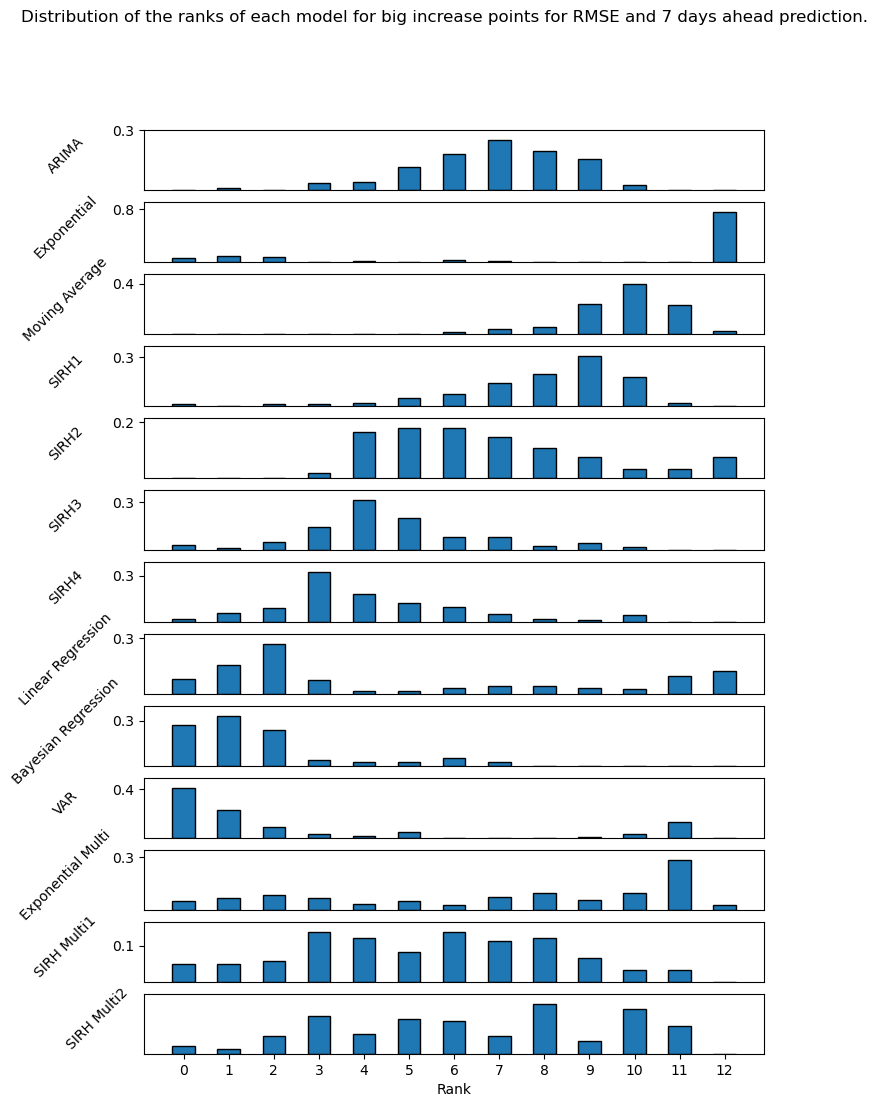

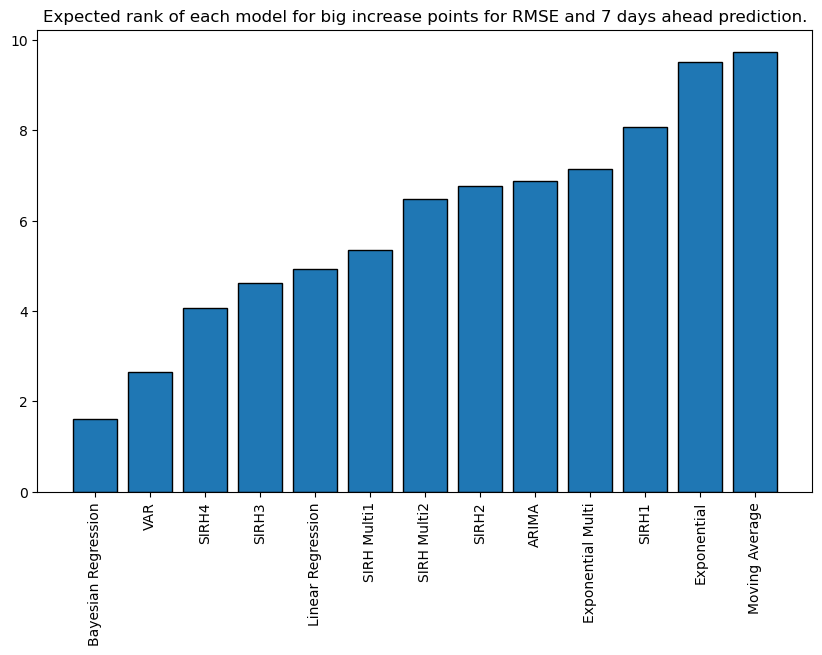

In [2]:
# from notebook 12


reach='7'
loss='RMSE'
models1Dnames=['ARIMA', 'Exponential', 'Moving Average', 'SIRH1', 'SIRH2', 'SIRH3', 'SIRH4', 'Linear Regression', 'Bayesian Regression']
models3Dnames=[ 'VAR', 'Exponential Multi', 'Moving Average Multi', 'SIRH Multi1', 'SIRH Multi2']

list_of_models= models1Dnames+models3Dnames
list_of_models.remove('Moving Average Multi')

df_expected_ranks=pd.DataFrame(columns= list_of_models, index = ['all','big increase', 'increase' , 'stable', 'inflexion', 'decrease', 'big decrease'] )



label_point = 'big increase'
all_ranks=np.zeros((len(list_of_models), len(list_of_models)))
results_list=[ name for name in os.listdir('./results/global_evaluation_from_zero_corrected/') if loss in name and '1D' in name and 'reach_='+str(reach) in name   ] # results of the models
for name in results_list :
    mob=int(name.split('_')[-5])
    pand=int(name.split('_')[-4])
    dicoresults1=df_to_dict(pd.read_csv('./results/global_evaluation_from_zero_corrected/'+name))
    dicoresults2=df_to_dict(pd.read_csv('./results/global_evaluation_from_zero_corrected/'+name.replace('1D', '3D')))
    dicoresults=concat_dico(dicoresults1, dicoresults2)
    df=pd.read_csv('./all_pandemics/pandemic_'+name.split('_')[-5]+'_'+name.split('_')[-4]+'.csv')
    df.index=['n_hospitalized', 'n_infectious', 'mobility', 'r_eff']
    df.drop(['Unnamed: 0'], axis=1, inplace=True)
    n_hospitalized = np.array(df.loc['n_hospitalized'])
    indexs_points=[[20*i] for i in range(1, 15) ] 
    prediction=pd.read_csv('./results/predictions_of_the_models_corrected/predictions_'+str(reach)+'_days_on_pandemic_'+str(mob)+'_'+str(pand)+'.csv')
    prediction.drop(['Unnamed: 0'], axis=1, inplace=True)
    prediction.index=[20*i for i in range(1, 15)]
    prediction_bis=prediction.drop(['Real values', 'Exponential', 'Exponential Multi'], axis=1)
    prediction_all=prediction
    prediction=prediction_bis
    for point in indexs_points: 
        if label_point=='all': 
            real_value=prediction_all['Real values'].loc[point[0]]
            perfs=dicoresults[str(point)]
            assert(len(perfs)==14)
            assert(abs(perfs[2] - perfs[11]) < 0.001, (perfs[2], perfs[11])) 
            perfs.pop(11) # remove the moving average multi
            assert(len(perfs)==13)
            rankings=get_classement(perfs)
            for i in range(len(rankings)): 
                rank_model_i=rankings[i]
                all_ranks[i][rank_model_i]+=1

        elif classify(point[0], n_hospitalized) == label_point :
            real_value=prediction_all['Real values'].loc[point[0]]
            perfs=dicoresults[str(point)]
            assert(len(perfs)==14)
            assert(abs(perfs[2] - perfs[11]) < 0.001, (perfs[2], perfs[11])) 
            perfs.pop(11) # remove the moving average multi
            assert(len(perfs)==13)
            rankings=get_classement(perfs)
            for i in range(len(rankings)): 
                rank_model_i=rankings[i]
                all_ranks[i][rank_model_i]+=1
            


fig, axs = plt.subplots(len(list_of_models), figsize=(8, 12))     
expected_ranks=[np.sum((np.array(all_ranks[i])/np.sum(np.array(all_ranks[i])))*np.array([i for i in range( len(rankings))])) for i in range(len(rankings))]   
    
for i in range(len(rankings)):   
    axs[i].bar([j for j in range(len(rankings))], np.array(all_ranks[i])/np.sum(np.array(all_ranks[i])), edgecolor='black', width = 0.5)
    axs[i].set_yticks([ round(np.max(np.array(all_ranks[i])/np.sum(np.array(all_ranks[i]))), 1) ])
    axs[i].set_ylim(bottom = 0 , top = (np.max(np.array(all_ranks[i])/np.sum(np.array(all_ranks[i]))))*1.2)
    axs[i].set_ylabel(list_of_models[i], labelpad=30)
    axs[i].yaxis.label.set_rotation(45)
    if i != len(rankings)-1:
        axs[i].set_xticks([])
    else : 
        axs[i].set_xticks([j for j in range(len(rankings))])
        axs[i].set_xlabel('Rank'  )
    fig.suptitle('Distribution of the ranks of each model for '+label_point+' points for '+loss+' and '+reach+' days ahead prediction.')

plt.show()
plt.figure(figsize=(10, 6))
exp_copy=expected_ranks.copy()
expected_ranks.sort()
df_expected_ranks.loc[label_point]=exp_copy
plt.bar(sort_list(list_of_models, exp_copy), expected_ranks, edgecolor='black')
plt.xticks(rotation=90)
plt.title('Expected rank of each model for '+label_point+' points for '+loss+' and '+reach+' days ahead prediction.')
plt.show()


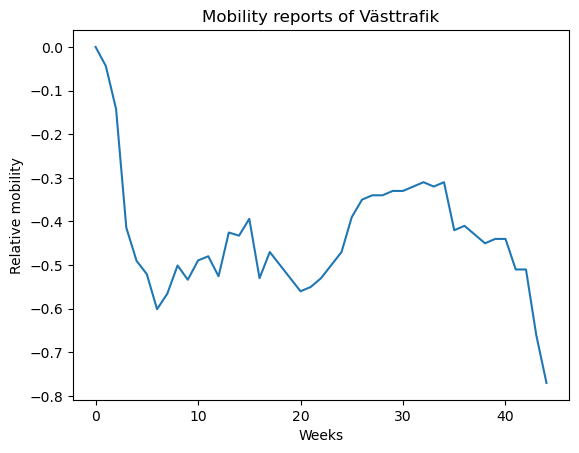

In [3]:
# from notebook 00
mobility='''0
-0,0436877025562212
-0,142183890633573
-0,414264196497882
-0,490226517606742
-0,520691444229291
-0,601104998394856
-0,565468289968282
-0,500887028474234
-0,533539503417897
-0,489363271950639
-0,479732407975015
-0,525650201055078
-0,4254
-0,4325
-0,394
-0,53
-0,47
-0,5
-0,53
-0,56
-0,55
-0,53
-0,5
-0,47
-0,39
-0,35
-0,34
-0,34
-0,33
-0,33
-0,32
-0,31
-0,32
-0,31
-0,42
-0,41
-0,43
-0,45
-0,44
-0,44
-0,51
-0,51
-0,66
-0,77
'''.replace(',','.').split('\n')


floatmobility = [float(i) for i in mobility if i != '']

plt.plot(floatmobility)
plt.title('Mobility reports of Västtrafik')
plt.ylabel('Relative mobility')
plt.xlabel('Weeks')
plt.show()

In [ ]:
# From notebook 00

if True:    
    all_simuls=[]
    for i in range(14): 
        coefs = [ 1 for _ in range(14)]
        coefs[i]=2
        params_custom = dict(
        pop_size=50000,
        start_day='2020-03-01',
        end_day='2021-03-01',
        pop_type='hybrid',
        beta=0.015,
        location='Sweden',
        pop_infected=10,
        dur={
            'exp2inf': {'dist':'lognormal_int', 'par1':4.5*coefs[0], 'par2':1.5}, # par 1 = mean of the log normal distrib, par 2 = std of the log normal distrib. par1 represents the expected value of the number of days between exposure and infection
            'inf2sym': {'dist':'lognormal_int', 'par1':1.1*coefs[1], 'par2':0.9},
            'sym2sev': {'dist':'lognormal_int', 'par1':6.6*coefs[2], 'par2':4.9},
            'sev2crit': {'dist':'lognormal_int', 'par1':1.5*coefs[3], 'par2':2.0},
            'asym2rec': {'dist':'lognormal_int', 'par1':8.0*coefs[4], 'par2':2.0},
            'mild2rec': {'dist':'lognormal_int', 'par1':8.0*coefs[5], 'par2':2.0},
            'sev2rec': {'dist':'lognormal_int', 'par1':18.1*coefs[6], 'par2':6.3},
            'crit2rec': {'dist':'lognormal_int', 'par1':18.1*coefs[7], 'par2':6.3},
            'crit2die': {'dist':'lognormal_int', 'par1':10.7*coefs[8], 'par2':4.8},
        }, 
        rel_symp_prob= 1.0*coefs[9],
        rel_severe_prob=1.0*coefs[10],
        rel_crit_prob=1.0*coefs[11],
        rel_death_prob=1.0*coefs[12]
        )
        
        # Define mobility coefficients and interventions
        all_days = cv.date_range(params_custom['start_day'], params_custom['end_day'])
        coef_mobility_custom = [1 for _ in range(len(all_days))]
        interventions_custom = cv.change_beta(days=all_days, changes=coef_mobility_custom, do_plot=False)

        # Create and run the simulation
        mysimul = cv.Sim(params_custom, interventions=interventions_custom)
        mysimul.run()
        all_simuls.append(np.array(mysimul.results['n_severe']))
        # Plot results
        plt.plot(mysimul.results['n_severe'])
        plt.xlabel('Day')
        plt.ylabel('Number of severe cases')
        plt.title('Number of severe cases over time with '+ str(i)+' -th parameter changed')
        plt.show()





fig, ax = plt.subplots(2, 2, figsize=(10, 8))

diff_max=0
imax=0
jmax=0
kmax=0
lmax=0

for i in range( 14):
    # print(i)
    for j in range(i+1, 14): 
        for k in range(j+1, 14): 
            for l in range(k+1, 14): 
                diff=dissemblance_1(all_simuls[i], all_simuls[j], all_simuls[k], all_simuls[l])
                if diff>diff_max: 
                    diff_max=diff
                    # print(i, j, k, l, diff_max)
                    imax=i
                    jmax=j
                    kmax=k
                    lmax=l
print('For dissemblance 1, the 4 most different pandemics are  '+str(imax)+', '+str(jmax)+', '+str(kmax)+', '+str(lmax)+' with a dissemblance of '+str(diff_max))


row=0
col=0

ax[row][col].plot(all_simuls[imax], label=str(imax))
ax[row][col].plot(all_simuls[jmax], label=str(jmax))
ax[row][col].plot(all_simuls[kmax], label=str(kmax))
ax[row][col].plot(all_simuls[lmax], label=str(lmax))

ax[row][col].legend()
ax[row][col].set_xlabel('Day')
ax[row][col].set_ylabel('Number of severe cases')
ax[row][col].set_title(r'4 most diverse simulations for $ \mathcal{L}_1$', fontsize=10)
ax[row][col].legend()
# ax[0][0].show()

diff_max=0
imax=0
jmax=0
kmax=0
lmax=0

for i in range( 14):
    # print(i)
    for j in range(i+1, 14): 
        for k in range(j+1, 14): 
            for l in range(k+1, 14): 
                diff=dissemblance_2(all_simuls[i], all_simuls[j], all_simuls[k], all_simuls[l])
                if diff>diff_max: 
                    diff_max=diff
                    # print(i, j, k, l, diff_max)
                    imax=i
                    jmax=j
                    kmax=k
                    lmax=l

print('For dissemblance 2, the 4 most different pandemics are  '+str(imax)+', '+str(jmax)+', '+str(kmax)+', '+str(lmax)+' with a dissemblance of '+str(diff_max))

row = 0 
col = 1

ax[row][col].plot(all_simuls[imax], label=str(imax))
ax[row][col].plot(all_simuls[jmax], label=str(jmax))
ax[row][col].plot(all_simuls[kmax], label=str(kmax))
ax[row][col].plot(all_simuls[lmax], label=str(lmax))

ax[row][col].legend()
ax[row][col].set_xlabel('Day')
ax[row][col].set_ylabel('Number of severe cases')
ax[row][col].set_title(r'4 most diverse simulations for $ \mathcal{L}_2 $', fontsize=10)
ax[row][col].legend()


diff_max=0
imax=0
jmax=0
kmax=0
lmax=0

for i in range( 14):
    # print(i)
    for j in range(i+1, 14): 
        for k in range(j+1, 14): 
            for l in range(k+1, 14): 
                diff=dissemblance_3(all_simuls[i], all_simuls[j], all_simuls[k], all_simuls[l])
                if diff>diff_max: 
                    diff_max=diff
                    # print(i, j, k, l, diff_max)
                    imax=i
                    jmax=j
                    kmax=k
                    lmax=l

print('For dissemblance 3, the 4 most different pandemics are  '+str(imax)+', '+str(jmax)+', '+str(kmax)+', '+str(lmax)+' with a dissemblance of '+str(diff_max))


row = 1
col = 0

ax[row][col].plot(all_simuls[imax], label=str(imax))
ax[row][col].plot(all_simuls[jmax], label=str(jmax))
ax[row][col].plot(all_simuls[kmax], label=str(kmax))
ax[row][col].plot(all_simuls[lmax], label=str(lmax))

ax[row][col].legend()
ax[row][col].set_xlabel('Day')
ax[row][col].set_ylabel('Number of severe cases')
ax[row][col].set_title(r'4 most diverse simulations for $ \mathcal{L}_3 $', fontsize=10)
ax[row][col].legend()

diff_max=0
imax=0
jmax=0
kmax=0
lmax=0

for i in range( 14):
    # print(i)
    for j in range(i+1, 14): 
        for k in range(j+1, 14): 
            for l in range(k+1, 14): 
                diff=dissemblance_4(all_simuls[i], all_simuls[j], all_simuls[k], all_simuls[l])
                if diff>diff_max: 
                    diff_max=diff
                    # print(i, j, k, l, diff_max)
                    imax=i
                    jmax=j
                    kmax=k
                    lmax=l

print('For dissemblance 4, the 4 most different pandemics are  '+str(imax)+', '+str(jmax)+', '+str(kmax)+', '+str(lmax)+' with a dissemblance of '+str(diff_max))

row=1
col=1
ax[row][col].plot(all_simuls[imax], label=str(imax))
ax[row][col].plot(all_simuls[jmax], label=str(jmax))
ax[row][col].plot(all_simuls[kmax], label=str(kmax))
ax[row][col].plot(all_simuls[lmax], label=str(lmax))

ax[row][col].legend()
ax[row][col].set_xlabel('Day')
ax[row][col].set_ylabel('Number of severe cases')
ax[row][col].set_title(r'4 most diverse simulations for $ \mathcal{L}_4 $', fontsize=10)
ax[row][col].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # rect ajuste l'espace pour le titre principal


plt.show()


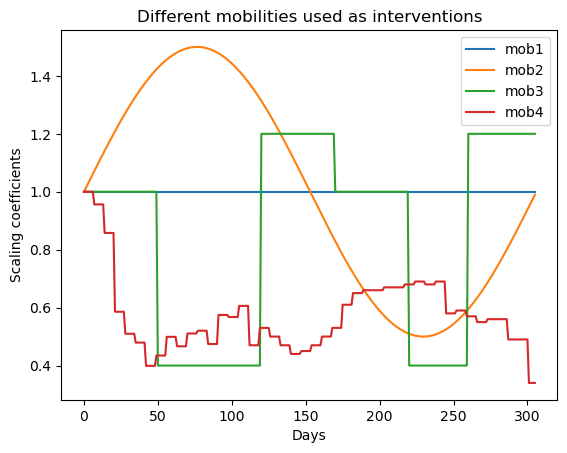

In [7]:
# from notebook 00
start_day = '2020-03-02'
end_day   = '2021-01-01'
end_day_bis='2020-07-01'
all_days = cv.date_range(start_day, end_day)

coef_mobility=[1+floatmobility[i] for i in range(len(floatmobility))]
coef_mobility_by_week=np.array([coef_mobility[i//7] for i in range(len(all_days))])

mob1=[1 for i in range(len(coef_mobility_by_week))]
mob2=[1+0.5*np.sin(2*np.pi*i/len(coef_mobility_by_week)) for i in range(len(coef_mobility_by_week))]
mob3=[1 for i in range(50)] + [ 0.4 for i in range(70)] + [ 1.2 for i in range(50)] + [1 for i in range(50)] + [ 0.4 for i in range(40)] + [ 1.2 for i in range(46)]

plt.plot(mob1, label='mob1')
plt.plot(mob2, label='mob2')
plt.plot(mob3, label='mob3')
plt.plot(coef_mobility_by_week, label='mob4')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Scaling coefficients')
plt.title('Different mobilities used as interventions')
plt.show()